# SMARTTRACK AI DEEP LEARNING ASSESSMENT

# AUTOENCODER for Performance Prediction and Fault Detection in a Photovoltaic System

**Name: HARISH WATHORE
<br>
Roll Number: 20101017
<br>
Department of Aerospace Engineering
<br>
Indian Institute of Technology Kanpur
<br>**


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [4]:

# Load normal data, data with no anomalies
normal_data = pd.read_csv('PV_dataset_4.csv')

# Load anomaly data
anomaly_data = pd.read_csv('PV_dataset_anomalies_v1_Pac.csv')



In [5]:
# Add labels for normal and anomaly data
normal_data['Label'] = 0  # 0 represents normal data
anomaly_data['Label'] = 1  # 1 represents anomalies


In [6]:
# Combine normal and anomaly data together
combined_data = pd.concat([normal_data, anomaly_data], ignore_index=True)



In [7]:
# Shuffle the combined dataset
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [8]:
# Extract features and labels for training
features = combined_data.drop('Label', axis=1)
labels = combined_data['Label']
target_pac = combined_data['Pac']

In [9]:
# Split the data into training and testing of anomaly detection and also split data for Power AC prediction

X_train, X_test, y_train, y_test, pac_train, pac_test = train_test_split(
    features, labels, target_pac, test_size=0.2, random_state=42
)

In [10]:
# Standardize the input features for faster convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Autoencoder Model for the anomaly detection
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(X_train_scaled.shape[1], activation=None)  
])

In [12]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
# Train the autoencoder on Normal Data
history = model.fit(
    X_train_scaled[y_train == 0],  # Use only normal data for training
    X_train_scaled[y_train == 0],  # Target is the same as input for autoencoder
    epochs=50,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/50
1021/1021 [==============================] - 3s 2ms/step - loss: 0.0589 - val_loss: 7.2471e-04
Epoch 2/50
1021/1021 [==============================] - 2s 2ms/step - loss: 4.7767e-04 - val_loss: 2.9371e-04
Epoch 3/50
1021/1021 [==============================] - 2s 2ms/step - loss: 2.4200e-04 - val_loss: 1.6749e-04
Epoch 4/50
1021/1021 [==============================] - 2s 2ms/step - loss: 1.6773e-04 - val_loss: 1.4714e-04
Epoch 5/50
1021/1021 [==============================] - 2s 2ms/step - loss: 1.4390e-04 - val_loss: 9.7641e-05
Epoch 6/50
1021/1021 [==============================] - 2s 2ms/step - loss: 1.2867e-04 - val_loss: 1.3912e-04
Epoch 7/50
1021/1021 [==============================] - 2s 2ms/step - loss: 1.0169e-04 - val_loss: 9.1585e-05
Epoch 8/50
1021/1021 [==============================] - 2s 2ms/step - loss: 9.4773e-05 - val_loss: 1.0777e-04
Epoch 9/50
1021/1021 [==============================] - 2s 2ms/step - loss: 8.5807e-05 - val_loss: 6.7326e-05
Epoch 10/50
10

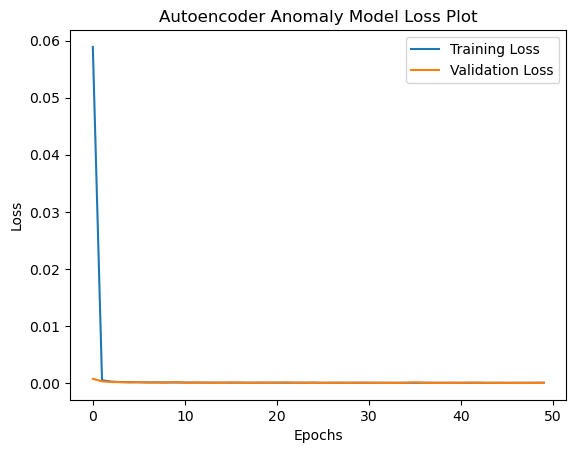

In [28]:
# Access the training loss and validation loss over epochs
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training loss and validation loss for Anomaly Detection
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Anomaly Model Loss Plot')
plt.show()


In [18]:
# Testing the autoencoder on the test set
test_predictions = model.predict(X_test_scaled)
test_mse = np.mean(np.square(X_test_scaled - test_predictions), axis=1)  # Mean squared error for each sample

# Setting a threshold for anomaly detection based on training performance
threshold_percentage = 90 #90 Because, the anomaly dataset I made had sudden 5% of Pac values drop by 90% because of sudden low voltage. 
threshold = np.percentile(test_mse, threshold_percentage)

# Identify the anomalies in our test set
test_anomalies = test_mse > threshold

# Print the number of anomalies present in the test set
print(f'Number of anomalies in the test set: {np.sum(test_anomalies)}')



639/639 [==============================] - 1s 1ms/step
Number of anomalies in the test set: 2042


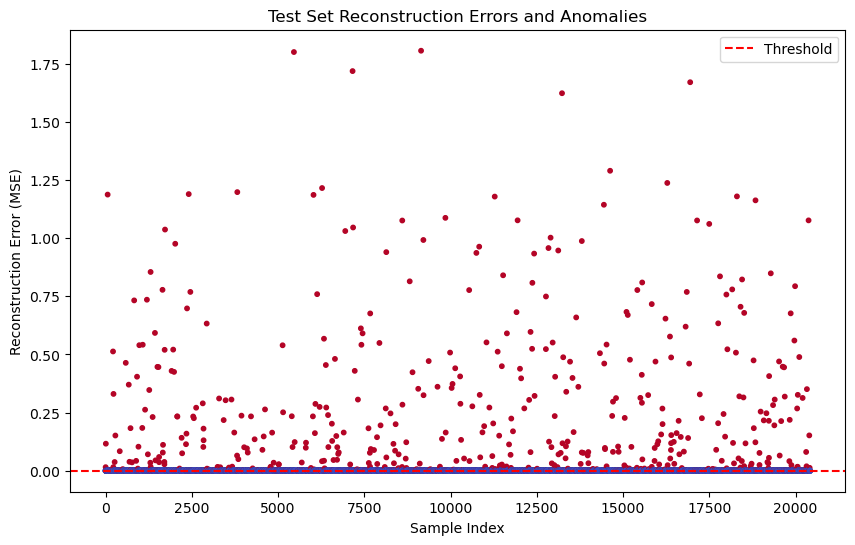

In [19]:
# Visualize the test set reconstruction errors
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(test_mse)), test_mse, c=test_anomalies, cmap='coolwarm', s=10)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Test Set Reconstruction Errors and Anomalies')
plt.legend()
plt.show()

In [14]:
# Fine-tune the autoencoder for Power AC prediction
model.pop()  # Remove the last layer (output layer)
model.add(tf.keras.layers.Dense(1, activation=None))  # Add a single output neuron for Pac prediction
model.compile(optimizer='adam', loss='mean_squared_error')


In [15]:

# Train the fine-tuned autoencoder for Power AC prediction
fine_tune_history = model.fit(
    X_train_scaled, pac_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)



Epoch 1/50
2042/2042 [==============================] - 5s 2ms/step - loss: 3619.9438 - val_loss: 16.1879
Epoch 2/50
2042/2042 [==============================] - 4s 2ms/step - loss: 9.3077 - val_loss: 4.3743
Epoch 3/50
2042/2042 [==============================] - 4s 2ms/step - loss: 3.2255 - val_loss: 1.6890
Epoch 4/50
2042/2042 [==============================] - 4s 2ms/step - loss: 2.2420 - val_loss: 0.8832
Epoch 5/50
2042/2042 [==============================] - 4s 2ms/step - loss: 1.7243 - val_loss: 0.6789
Epoch 6/50
2042/2042 [==============================] - 4s 2ms/step - loss: 1.5996 - val_loss: 0.6361
Epoch 7/50
2042/2042 [==============================] - 4s 2ms/step - loss: 1.2145 - val_loss: 0.6606
Epoch 8/50
2042/2042 [==============================] - 4s 2ms/step - loss: 3.4856 - val_loss: 0.8145
Epoch 9/50
2042/2042 [==============================] - 4s 2ms/step - loss: 1.2641 - val_loss: 0.6091
Epoch 10/50
2042/2042 [==============================] - 4s 2ms/step - loss: 1

In [16]:
# Evaluating the fine-tuned model on the test set
pac_predictions = model.predict(X_test_scaled)
mse_pac = mean_squared_error(pac_test, pac_predictions.flatten())
print(f'Mean Squared Error on Test Set for Pac prediction: {mse_pac}')

639/639 [==============================] - 1s 1ms/step
Mean Squared Error on Test Set for Pac prediction: 0.5602977927849724


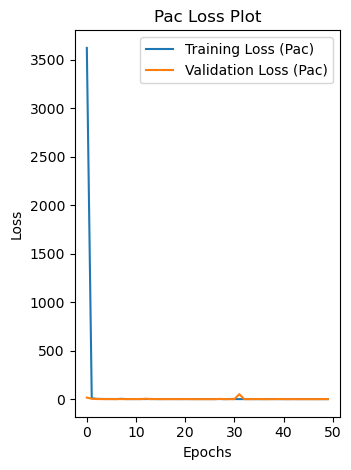

In [18]:
# Visualize the training loss and validation loss for the Power AC prediction task
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Training Loss (Pac)')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss (Pac)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Pac Loss Plot')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Evaluate the fine-tuned model on the test set
pac_predictions = model.predict(X_test_scaled)

# Create a DataFrame with true values, predictions, and features
result_df = pd.DataFrame({
    'True_Pac': pac_test,
    'Predicted_Pac': pac_predictions.flatten(),
    'Tm': X_test['Tm'],
    'Ta': X_test['Ta'],
    'Gir': X_test['Gir']
})

# Sort the DataFrame based on ascending values of 'Ta' and 'Gir'
result_df_sorted = result_df.sort_values(by=['Ta', 'Gir'])

# Save the sorted DataFrame to a CSV file
result_df_sorted.to_csv('auto_encoder_pac_predictions_sorted.csv', index=False)

639/639 [==============================] - 1s 1ms/step


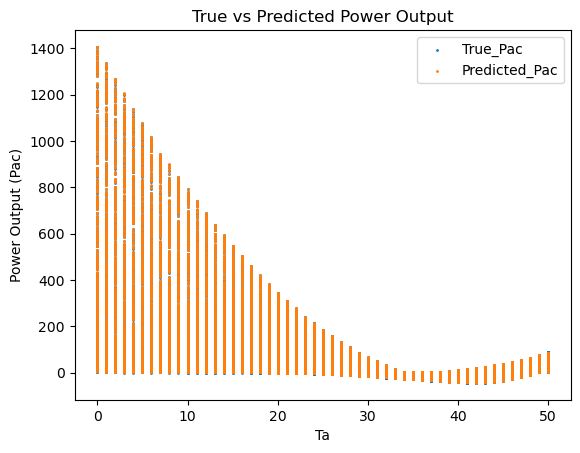

In [20]:

# Load the predictions with features from the CSV file
import_df = pd.read_csv('auto_encoder_pac_predictions_sorted.csv')

# Plot 'Ta' vs 'True_Pac' and 'Predicted_Pac' with smaller points
plt.scatter(import_df['Ta'], import_df['True_Pac'], label='True_Pac', s=1)  # Adjust 's' for size
plt.scatter(import_df['Ta'], import_df['Predicted_Pac'], label='Predicted_Pac', s=1)  # Adjust 's' for size
plt.xlabel('Ta')
plt.ylabel('Power Output (Pac)')
plt.title('True vs Predicted Power Output')
plt.legend()
plt.show()

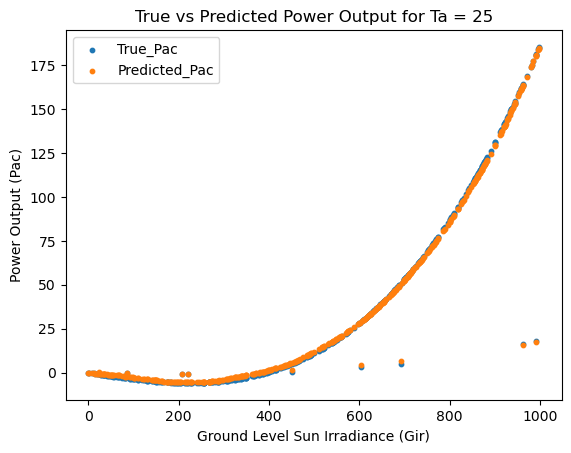

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions with features from the CSV file
import_df = pd.read_csv('auto_encoder_pac_predictions_sorted.csv')

# Filter the DataFrame for Ta = 25
selected_ta_df = import_df[import_df['Ta'] == 25]

# Plot 'Gir' vs 'True_Pac' and 'Predicted_Pac' for Ta = 25
plt.scatter(selected_ta_df['Gir'], selected_ta_df['True_Pac'], label='True_Pac', s=10)
plt.scatter(selected_ta_df['Gir'], selected_ta_df['Predicted_Pac'], label='Predicted_Pac', s=10)
plt.xlabel('Ground Level Sun Irradiance (Gir)')
plt.ylabel('Power Output (Pac)')
plt.title('True vs Predicted Power Output for Ta = 25')
plt.legend()
plt.show()